In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline
import seaborn as sns


In [2]:
df = pd.read_csv("Br_vegetation_with_City.csv")
df.head()

,date,name,geocode,vim,vim_avg,viq
0,2002-07-01,Nilópolis,3303203,0.4761,0.4963,96.3034
1,2002-07-11,Nilópolis,3303203,0.4692,0.4844,97.1523
2,2002-07-21,Nilópolis,3303203,0.4605,0.4710,97.9752
3,2002-08-01,Nilópolis,3303203,0.4511,0.4589,98.4673
4,2002-08-11,Nilópolis,3303203,0.4422,0.4493,98.5854


In [3]:
df.isnull().sum()


date       0
name       0
geocode    0
vim        0
vim_avg    0
viq        0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72709 entries, 0 to 72708
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     72709 non-null  object 
 1   name     72709 non-null  object 
 2   geocode  72709 non-null  int64  
 3   vim      72709 non-null  float64
 4   vim_avg  72709 non-null  float64
 5   viq      72709 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 3.3+ MB


In [5]:
# Filter rows where the date is on or after '2012-01-01'
df = df[
    (df['date'] >= '2012-01-01') & 
    (df['date'] <= '2022-12-31')
]

# Display the filtered dataset inf
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36036 entries, 342 to 72647
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     36036 non-null  object 
 1   name     36036 non-null  object 
 2   geocode  36036 non-null  int64  
 3   vim      36036 non-null  float64
 4   vim_avg  36036 non-null  float64
 5   viq      36036 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.9+ MB


MONTHLY INTERPOLATION

In [6]:
# Ensure 'date' column is of datetime type
df['date'] = pd.to_datetime(df['date'])

# Extract year and month from the date for monthly aggregation
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Monthly aggregation: Calculate monthly mean of 'vim', 'vim_avg', 'viq'
monthly_vegetation = df.groupby(['geocode', 'year', 'month']).agg({
    'vim': 'mean',
    'vim_avg': 'mean',
    'viq': 'mean'
}).reset_index()

monthly_vegetation.head()

,geocode,year,month,vim,vim_avg,viq
0,3300100,2012,1,0.852633,0.857233,99.495800
1,3300100,2012,2,0.858000,0.864000,99.344433
2,3300100,2012,3,0.861567,0.867967,99.302833
3,3300100,2012,4,0.863667,0.868800,99.441267
4,3300100,2012,5,0.863833,0.865667,99.801567


In [7]:
monthly_vegetation = monthly_vegetation.rename(columns={'vim': 'vim_monthly'})
monthly_vegetation.head(15)


,geocode,year,month,vim_monthly,vim_avg,viq
0,3300100,2012,1,0.852633,0.857233,99.495800
1,3300100,2012,2,0.858000,0.864000,99.344433
2,3300100,2012,3,0.861567,0.867967,99.302833
3,3300100,2012,4,0.863667,0.868800,99.441267
4,3300100,2012,5,0.863833,0.865667,99.801567
5,3300100,2012,6,0.861067,0.859100,100.217967
6,3300100,2012,7,0.854900,0.850333,100.510467
7,3300100,2012,8,0.847200,0.842567,100.517900
8,3300100,2012,9,0.841933,0.837800,100.467033
9,3300100,2012,10,0.842233,0.837500,100.532267


WEEKLY INTERPOLATION USING CUBIC SPLINE

In [8]:
df = df.sort_values(by=['geocode', 'date'])
print(df)

            date            name  geocode     vim  vim_avg       viq  month  \
36297 2012-01-01  Angra dos Reis  3300100  0.8505   0.8544   99.5724      1   
36298 2012-01-11  Angra dos Reis  3300100  0.8527   0.8574   99.4879      1   
36299 2012-01-21  Angra dos Reis  3300100  0.8547   0.8599   99.4271      1   
36300 2012-02-01  Angra dos Reis  3300100  0.8565   0.8622   99.3780      2   
36301 2012-02-11  Angra dos Reis  3300100  0.8581   0.8641   99.3404      2   
...          ...             ...      ...     ...      ...       ...    ...   
70246 2022-11-11   Volta Redonda  3306305  0.6422   0.6328  101.3823     11   
70247 2022-11-21   Volta Redonda  3306305  0.6704   0.6526  102.5213     11   
70248 2022-12-01   Volta Redonda  3306305  0.6966   0.6692  103.8161     12   
70249 2022-12-11   Volta Redonda  3306305  0.7191   0.6817  105.1096     12   
70250 2022-12-21   Volta Redonda  3306305  0.7350   0.6904  106.0223     12   

       year  
36297  2012  
36298  2012  
36299  20

In [9]:

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['geocode', 'date'])

# Define the function for spline interpolation on 'vim' for each geo code
def interpolate_vim_spline(group):
    # Extract year for the group
    group['year'] = group['date'].dt.year
    
    # Define an empty DataFrame to store the results
    interpolated_df = pd.DataFrame()

    # Loop through each year in the group and interpolate separately
    for year in group['year'].unique():
        year_group = group[group['year'] == year]
        
        # Convert date to ordinal (number of days since 1970-01-01)
        year_group['date_ordinal'] = (year_group['date'] - pd.Timestamp('1970-01-01')).dt.days
        
        # Create a cubic spline interpolator for 'vim' values
        spline = CubicSpline(year_group['date_ordinal'], year_group['vim'], bc_type='natural')
        
        # Generate weekly date intervals for the year
        weekly_dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='7D')
        
        # Convert weekly dates to ordinal (days since 1970-01-01)
        weekly_ordinals = (weekly_dates - pd.Timestamp('1970-01-01')).days
        
        # Interpolate the 'vim' values for the weekly dates
        weekly_vim = spline(weekly_ordinals)
        
        # Calculate custom year-week values
        start_of_year = pd.Timestamp(f'{year}-01-01')
        weekly_year_week = ((weekly_dates - start_of_year).days // 7 + 1).astype(int).astype(str)
        weekly_year_week = weekly_dates.year.astype(str) + weekly_year_week.str.zfill(2)
        
        # Create a DataFrame for the interpolated values for the year
        year_interpolated_df = pd.DataFrame({
            'date': weekly_dates,
            'vim': weekly_vim,
            'geocode': year_group['geocode'].iloc[0],  # Use the first geocode of the year group
            'week': weekly_year_week  # Add the custom year-week column
        })
        
        # Append the result for this year to the overall DataFrame
        interpolated_df = pd.concat([interpolated_df, year_interpolated_df], ignore_index=True)
    
    return interpolated_df

# Apply the spline interpolation function for each geo code
df_interpolated_spline = df.groupby('geocode').apply(interpolate_vim_spline).reset_index(drop=True)

df_interpolated_spline.head(65)


C:\Users\user\AppData\Local\Temp\ipykernel_9076\328760175.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_interpolated_spline = df.groupby('geocode').apply(interpolate_vim_spline).reset_index(drop=True)


,date,vim,geocode,week
0,2012-01-01,0.850500,3300100,201201
1,2012-01-08,0.852050,3300100,201202
2,2012-01-15,0.853541,3300100,201203
3,2012-01-22,0.854877,3300100,201204
4,2012-01-29,0.856021,3300100,201205
...,...,...,...,...
60,2013-02-19,0.873353,3300100,201308
61,2013-02-26,0.874238,3300100,201309
62,2013-03-05,0.875015,3300100,201310
63,2013-03-12,0.875567,3300100,201311


In [10]:
df_interpolated_spline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53053 entries, 0 to 53052
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     53053 non-null  datetime64[ns]
 1   vim      53053 non-null  float64       
 2   geocode  53053 non-null  int64         
 3   week     53053 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [11]:
df_interpolated_spline.nunique()

date         583
vim        50698
geocode       91
week         583
dtype: int64

In [12]:
dengue_df = pd.read_csv("52_week_dengue_dataset.csv")
dengue_df = dengue_df.sort_values(by=['geo_code', 'date'])
dengue_df.head()

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geo_code
51,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100
50,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100
49,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100
48,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100
47,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100


In [13]:
dengue_df.tail()

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geo_code
52760,2022-11-27,202248,1,273988.0,21.857143,95.875069,82.840922,61.313170,25.507143,30.857143,Volta Redonda,3306305
52759,2022-12-04,202249,0,273988.0,21.857143,92.543531,80.151192,64.110460,24.903139,28.142857,Volta Redonda,3306305
52758,2022-12-11,202250,2,273988.0,21.000000,94.213747,79.480439,59.964030,24.597222,28.500000,Volta Redonda,3306305
52757,2022-12-18,202251,1,273988.0,21.000000,91.312065,84.229947,73.950180,23.184295,26.000000,Volta Redonda,3306305
52756,2022-12-25,202252,0,273988.0,22.333333,92.282320,83.456510,71.528758,24.840404,27.666667,Volta Redonda,3306305


In [14]:
dengue_df = dengue_df.rename(columns={'geo_code': 'geocode'})
dengue_df.head()

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode
51,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100
50,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100
49,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100
48,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100
47,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100


In [15]:
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52808 entries, 51 to 52756
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          52808 non-null  object 
 1   week          52808 non-null  int64  
 2   cases         52808 non-null  int64  
 3   population    52808 non-null  float64
 4   tempe_min     52808 non-null  float64
 5   humidity_max  50828 non-null  float64
 6   humidity_avg  50828 non-null  float64
 7   humidity_min  50828 non-null  float64
 8   temp_avg      50828 non-null  float64
 9   temp_max      50828 non-null  float64
 10  city          52808 non-null  object 
 11  geocode       52808 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 5.2+ MB


In [16]:
df_interpolated_spline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53053 entries, 0 to 53052
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     53053 non-null  datetime64[ns]
 1   vim      53053 non-null  float64       
 2   geocode  53053 non-null  int64         
 3   week     53053 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [17]:
# Convert 'week' in dengue_df to string to match the type in df_interpolated_spline
dengue_df['week'] = dengue_df['week'].astype(str)

# Ensure 'week' in df_interpolated_spline is a string (already is, but for safety)
df_interpolated_spline['week'] = df_interpolated_spline['week'].astype(str)

# Perform the merge
dengue_df_merged = pd.merge(
    dengue_df,
    df_interpolated_spline[['geocode', 'week', 'vim']],  # Select relevant columns from interpolated DataFrame
    on=['geocode', 'week'],  # Merge on 'geocode' and 'week'
    how='left'  # Use a left join to retain all rows from dengue_df
)

# Display the merged DataFrame
dengue_df_merged.head()

# Display the shape of the merged DataFrame


,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100,0.850500
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100,0.852050
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100,0.853541
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100,0.854877
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100,0.856021


In [18]:
dengue_df_merged.tail()


,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim
52803,2022-11-27,202248,1,273988.0,21.857143,95.875069,82.840922,61.313170,25.507143,30.857143,Volta Redonda,3306305,0.683798
52804,2022-12-04,202249,0,273988.0,21.857143,92.543531,80.151192,64.110460,24.903139,28.142857,Volta Redonda,3306305,0.701526
52805,2022-12-11,202250,2,273988.0,21.000000,94.213747,79.480439,59.964030,24.597222,28.500000,Volta Redonda,3306305,0.717158
52806,2022-12-18,202251,1,273988.0,21.000000,91.312065,84.229947,73.950180,23.184295,26.000000,Volta Redonda,3306305,0.729156
52807,2022-12-25,202252,0,273988.0,22.333333,92.282320,83.456510,71.528758,24.840404,27.666667,Volta Redonda,3306305,0.739351


In [19]:
dengue_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52808 entries, 0 to 52807
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          52808 non-null  object 
 1   week          52808 non-null  object 
 2   cases         52808 non-null  int64  
 3   population    52808 non-null  float64
 4   tempe_min     52808 non-null  float64
 5   humidity_max  50828 non-null  float64
 6   humidity_avg  50828 non-null  float64
 7   humidity_min  50828 non-null  float64
 8   temp_avg      50828 non-null  float64
 9   temp_max      50828 non-null  float64
 10  city          52808 non-null  object 
 11  geocode       52808 non-null  int64  
 12  vim           52234 non-null  float64
dtypes: float64(8), int64(2), object(3)
memory usage: 5.2+ MB


In [20]:
dengue_df_merged.isnull().sum()

date               0
week               0
cases              0
population         0
tempe_min          0
humidity_max    1980
humidity_avg    1980
humidity_min    1980
temp_avg        1980
temp_max        1980
city               0
geocode            0
vim              574
dtype: int64

In [21]:
#drop all the columns of mesquita
# Remove rows where the 'city' is equal to 'Mesquita'
dengue_df_merged = dengue_df_merged[dengue_df_merged['city'] != 'Mesquita']

# Verify the removal
print(dengue_df_merged['city'].nunique())

91


In [22]:
dengue_df_merged.isnull().sum()

date               0
week               0
cases              0
population         0
tempe_min          0
humidity_max    1957
humidity_avg    1957
humidity_min    1957
temp_avg        1957
temp_max        1957
city               0
geocode            0
vim                0
dtype: int64

In [23]:

dengue_df_merged['date'] = pd.to_datetime(dengue_df_merged['date'])

dengue_df_merged['year'] = dengue_df_merged['date'].dt.year
dengue_df_merged['month'] = dengue_df_merged['date'].dt.month
dengue_df_merged.head(10)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,year,month
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100,0.850500,2012,1
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100,0.852050,2012,1
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100,0.853541,2012,1
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100,0.854877,2012,1
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100,0.856021,2012,1
5,2012-02-05,201206,39,207044.0,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,Angra dos Reis,3300100,0.857159,2012,2
6,2012-02-12,201207,37,207044.0,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,Angra dos Reis,3300100,0.858241,2012,2
7,2012-02-19,201208,33,207044.0,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,Angra dos Reis,3300100,0.859142,2012,2
8,2012-02-26,201209,46,207044.0,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,Angra dos Reis,3300100,0.860082,2012,2
9,2012-03-04,201210,42,207044.0,20.428571,71.714286,48.333639,28.428571,26.467491,30.857143,Angra dos Reis,3300100,0.860933,2012,3


In [24]:
monthly_vegetation.head(10)

,geocode,year,month,vim_monthly,vim_avg,viq
0,3300100,2012,1,0.852633,0.857233,99.495800
1,3300100,2012,2,0.858000,0.864000,99.344433
2,3300100,2012,3,0.861567,0.867967,99.302833
3,3300100,2012,4,0.863667,0.868800,99.441267
4,3300100,2012,5,0.863833,0.865667,99.801567
5,3300100,2012,6,0.861067,0.859100,100.217967
6,3300100,2012,7,0.854900,0.850333,100.510467
7,3300100,2012,8,0.847200,0.842567,100.517900
8,3300100,2012,9,0.841933,0.837800,100.467033
9,3300100,2012,10,0.842233,0.837500,100.532267


In [25]:
monthly_vegetation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12012 entries, 0 to 12011
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geocode      12012 non-null  int64  
 1   year         12012 non-null  int32  
 2   month        12012 non-null  int32  
 3   vim_monthly  12012 non-null  float64
 4   vim_avg      12012 non-null  float64
 5   viq          12012 non-null  float64
dtypes: float64(3), int32(2), int64(1)
memory usage: 469.3 KB


In [26]:
dengue_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52234 entries, 0 to 52807
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          52234 non-null  datetime64[ns]
 1   week          52234 non-null  object        
 2   cases         52234 non-null  int64         
 3   population    52234 non-null  float64       
 4   tempe_min     52234 non-null  float64       
 5   humidity_max  50277 non-null  float64       
 6   humidity_avg  50277 non-null  float64       
 7   humidity_min  50277 non-null  float64       
 8   temp_avg      50277 non-null  float64       
 9   temp_max      50277 non-null  float64       
 10  city          52234 non-null  object        
 11  geocode       52234 non-null  int64         
 12  vim           52234 non-null  float64       
 13  year          52234 non-null  int32         
 14  month         52234 non-null  int32         
dtypes: datetime64[ns](1), float64(8), int32(2

In [27]:

dengue_df_merged = pd.merge(dengue_df_merged,
                            monthly_vegetation[['geocode', 'year', 'month', 'vim_monthly']], 
                            on=['geocode', 'year', 'month'], 
                            how='left')

dengue_df_merged.head(10)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,year,month,vim_monthly
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100,0.850500,2012,1,0.852633
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100,0.852050,2012,1,0.852633
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100,0.853541,2012,1,0.852633
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100,0.854877,2012,1,0.852633
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100,0.856021,2012,1,0.852633
5,2012-02-05,201206,39,207044.0,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,Angra dos Reis,3300100,0.857159,2012,2,0.858000
6,2012-02-12,201207,37,207044.0,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,Angra dos Reis,3300100,0.858241,2012,2,0.858000
7,2012-02-19,201208,33,207044.0,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,Angra dos Reis,3300100,0.859142,2012,2,0.858000
8,2012-02-26,201209,46,207044.0,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,Angra dos Reis,3300100,0.860082,2012,2,0.858000
9,2012-03-04,201210,42,207044.0,20.428571,71.714286,48.333639,28.428571,26.467491,30.857143,Angra dos Reis,3300100,0.860933,2012,3,0.861567


In [28]:
dengue_df_merged.isnull().sum()

date               0
week               0
cases              0
population         0
tempe_min          0
humidity_max    1957
humidity_avg    1957
humidity_min    1957
temp_avg        1957
temp_max        1957
city               0
geocode            0
vim                0
year               0
month              0
vim_monthly        0
dtype: int64

In [29]:
dengue_df_merged = dengue_df_merged.drop(columns=['year', 'month'])



In [30]:
dengue_df_merged.head(107)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,Angra dos Reis,3300100,0.850500,0.852633
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,Angra dos Reis,3300100,0.852050,0.852633
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,Angra dos Reis,3300100,0.853541,0.852633
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,Angra dos Reis,3300100,0.854877,0.852633
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,Angra dos Reis,3300100,0.856021,0.852633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2013-12-15,201351,13,207044.0,18.285714,88.857143,65.686507,48.285714,23.587103,27.857143,Angra dos Reis,3300100,0.845203,0.844000
103,2013-12-22,201352,17,207044.0,19.285714,93.142857,66.800182,46.000000,25.572711,30.142857,Angra dos Reis,3300100,0.846597,0.844000
104,2013-12-29,201401,4,207044.0,21.000000,92.285714,64.142123,39.000000,27.434524,33.142857,Angra dos Reis,3300100,0.848400,0.844000
105,2014-01-05,201402,20,207044.0,19.428571,88.285714,56.292750,33.428571,27.280067,32.714286,Angra dos Reis,3300100,0.849975,0.850467


In [31]:
ordinary_krigging = pd.read_csv('knn_imputed_precipitation_ordinary_kriging.csv')
regression_krigging=pd.read_csv('knn_imputed_precipitation_kriging_level_regression.csv')



In [32]:
ordinary_krigging.head()

,week,precipitation_avg,precipitation_max,CITY
0,201201,5.6804,18.3375,Angra Dos Reis
1,201202,4.0716,16.5375,Angra Dos Reis
2,201203,2.0555,5.0500,Angra Dos Reis
3,201204,1.5416,5.7059,Angra Dos Reis
4,201205,2.8204,9.3826,Angra Dos Reis


In [33]:
ordinary_krigging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52808 entries, 0 to 52807
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               52808 non-null  int64  
 1   precipitation_avg  52808 non-null  float64
 2   precipitation_max  52808 non-null  float64
 3   CITY               52808 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.6+ MB


In [34]:
# Ensure the 'week' column is of type string in both kriging DataFrames
ordinary_krigging['week'] = ordinary_krigging['week'].astype(str)
regression_krigging['week'] = regression_krigging['week'].astype(str)


In [35]:
regression_krigging.head()

,week,precipitation_avg,precipitation_max,CITY
0,201201,5.2038,18.7979,Angra Dos Reis
1,201202,3.9114,16.8583,Angra Dos Reis
2,201203,1.7556,3.1368,Angra Dos Reis
3,201204,1.4138,5.2767,Angra Dos Reis
4,201205,2.0057,7.8749,Angra Dos Reis


In [36]:
# Rename columns for ordinary_krigging
ordinary_krigging.rename(
    columns={
        "precipitation_avg": "precipitation_avg_ordinary_krigging",
        "precipitation_max": "precipitation_max_ordinary_krigging",
        "CITY":"city",
    },
    inplace=True
)

# Rename columns for regression_krigging
regression_krigging.rename(
    columns={
        "precipitation_avg": "precipitation_avg_regression_krigging",
        "precipitation_max": "precipitation_max_regression_krigging",
        "CITY":"city",

    },
    inplace=True
)


In [37]:
ordinary_krigging.head()

,week,precipitation_avg_ordinary_krigging,precipitation_max_ordinary_krigging,city
0,201201,5.6804,18.3375,Angra Dos Reis
1,201202,4.0716,16.5375,Angra Dos Reis
2,201203,2.0555,5.0500,Angra Dos Reis
3,201204,1.5416,5.7059,Angra Dos Reis
4,201205,2.8204,9.3826,Angra Dos Reis


In [38]:
regression_krigging.head()

,week,precipitation_avg_regression_krigging,precipitation_max_regression_krigging,city
0,201201,5.2038,18.7979,Angra Dos Reis
1,201202,3.9114,16.8583,Angra Dos Reis
2,201203,1.7556,3.1368,Angra Dos Reis
3,201204,1.4138,5.2767,Angra Dos Reis
4,201205,2.0057,7.8749,Angra Dos Reis


In [39]:

dengue_df_merged['city'] = dengue_df_merged['city'].str.strip().str.lower()
ordinary_krigging['city'] = ordinary_krigging['city'].str.strip().str.lower()
regression_krigging['city'] = regression_krigging['city'].str.strip().str.lower()

# Ensure 'week' is a string in both DataFrames
dengue_df_merged['week'] = dengue_df_merged['week'].astype(str)
ordinary_krigging['week'] = ordinary_krigging['week'].astype(str)
regression_krigging['week'] = regression_krigging['week'].str.strip().str.lower()


In [40]:
dengue_df_merged = pd.merge(dengue_df_merged,
                            ordinary_krigging[['week', 'city', 'precipitation_avg_ordinary_krigging', 'precipitation_max_ordinary_krigging']], 
                            on=['week', 'city'], 
                            how='left')

dengue_df_merged.head(70)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_krigging,precipitation_max_ordinary_krigging
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2013-03-31,201314,612,207044.0,20.285714,97.428571,76.640063,56.000000,24.900870,28.571429,angra dos reis,3300100,0.876090,0.875367,2.5207,12.3094
66,2013-04-07,201315,709,207044.0,20.142857,87.428571,73.522143,58.857143,23.513070,26.571429,angra dos reis,3300100,0.875956,0.875800,1.7950,8.0429
67,2013-04-14,201316,537,207044.0,15.285714,89.714286,68.131868,50.571429,20.725275,24.714286,angra dos reis,3300100,0.875715,0.875800,0.8844,4.7219
68,2013-04-21,201317,286,207044.0,14.000000,93.142857,63.929012,44.428571,20.488535,24.857143,angra dos reis,3300100,0.875220,0.875800,0.3933,1.4821


In [41]:
dengue_df_merged = pd.merge(dengue_df_merged,
                            regression_krigging[['week', 'city', 'precipitation_avg_regression_krigging', 'precipitation_max_regression_krigging']], 
                            on=['week', 'city'], 
                            how='left')

In [42]:
dengue_df_merged.head()

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_krigging,precipitation_max_ordinary_krigging,precipitation_avg_regression_krigging,precipitation_max_regression_krigging
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749


PREPROCESSING - PART

In [43]:
df = dengue_df_merged


In [44]:
df.shape

(52234, 18)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52234 entries, 0 to 52233
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   52234 non-null  datetime64[ns]
 1   week                                   52234 non-null  object        
 2   cases                                  52234 non-null  int64         
 3   population                             52234 non-null  float64       
 4   tempe_min                              52234 non-null  float64       
 5   humidity_max                           50277 non-null  float64       
 6   humidity_avg                           50277 non-null  float64       
 7   humidity_min                           50277 non-null  float64       
 8   temp_avg                               50277 non-null  float64       
 9   temp_max                               50277 non-null  float6

In [46]:
# Convert 'geocode' column to object type
df['geocode'] = df['geocode'].astype('str')

# Verify the change
print(df.dtypes)


date                                     datetime64[ns]
week                                             object
cases                                             int64
population                                      float64
tempe_min                                       float64
humidity_max                                    float64
humidity_avg                                    float64
humidity_min                                    float64
temp_avg                                        float64
temp_max                                        float64
city                                             object
geocode                                          object
vim                                             float64
vim_monthly                                     float64
precipitation_avg_ordinary_krigging             float64
precipitation_max_ordinary_krigging             float64
precipitation_avg_regression_krigging           float64
precipitation_max_regression_krigging           

In [47]:
#count of missing values
df.isnull().sum()

date                                        0
week                                        0
cases                                       0
population                                  0
tempe_min                                   0
humidity_max                             1957
humidity_avg                             1957
humidity_min                             1957
temp_avg                                 1957
temp_max                                 1957
city                                        0
geocode                                     0
vim                                         0
vim_monthly                                 0
precipitation_avg_ordinary_krigging         0
precipitation_max_ordinary_krigging         0
precipitation_avg_regression_krigging       0
precipitation_max_regression_krigging       0
dtype: int64

In [48]:
#percentage of missing values
df.isnull().sum()/df.shape[0] * 100
#if greater than 50 delte the column

date                                     0.000000
week                                     0.000000
cases                                    0.000000
population                               0.000000
tempe_min                                0.000000
humidity_max                             3.746602
humidity_avg                             3.746602
humidity_min                             3.746602
temp_avg                                 3.746602
temp_max                                 3.746602
city                                     0.000000
geocode                                  0.000000
vim                                      0.000000
vim_monthly                              0.000000
precipitation_avg_ordinary_krigging      0.000000
precipitation_max_ordinary_krigging      0.000000
precipitation_avg_regression_krigging    0.000000
precipitation_max_regression_krigging    0.000000
dtype: float64

In [49]:
#find duplicates
df.duplicated().sum()

0

In [50]:
#find garbage values
#column type does not match the data type for that rows data
for i in df.select_dtypes(include="object").columns:
    print(df[i].value_counts())
    print("***"* 10)

week
201201    91
201921    91
201915    91
201916    91
201917    91
          ..
201529    91
201528    91
201527    91
201526    91
202252    91
Name: count, Length: 574, dtype: int64
******************************
city
angra dos reis                 574
santo antônio de pádua         574
rio de janeiro                 574
rio das ostras                 574
rio das flores                 574
                              ... 
itaboraí                       574
iguaba grande                  574
guapimirim                     574
engenheiro paulo de frontin    574
volta redonda                  574
Name: count, Length: 91, dtype: int64
******************************
geocode
3300100    574
3304706    574
3304557    574
3304524    574
3304508    574
          ... 
3301900    574
3301876    574
3301850    574
3301801    574
3306305    574
Name: count, Length: 91, dtype: int64
******************************


EXPLOITARY DATA ANALYSIS (EDA)

In [51]:
#descriptive statics
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,52234,2017-06-28 11:49:57.909407488,2012-01-01 00:00:00,2014-09-28 00:00:00,2017-06-28 12:00:00,2020-03-29 00:00:00,2022-12-25 00:00:00,NaN
cases,52234.0,16.520389,0.0,0.0,0.0,3.0,14708.0,209.313216
population,52234.0,188896.923077,5623.0,18648.0,37083.0,134819.0,6747815.0,717576.847309
tempe_min,52234.0,20.646165,5.714286,18.714286,21.0,22.96,26.857143,2.900718
humidity_max,50277.0,92.231048,56.571429,89.428571,92.333333,95.0,3114.169465,23.798306
humidity_avg,50277.0,77.817627,38.501962,72.334957,78.336191,84.072223,200.7106,8.640709
humidity_min,50277.0,61.14747,18.857143,49.571429,59.571429,73.541317,100.0,15.281496
temp_avg,50277.0,23.781664,8.714286,21.919048,24.029503,25.797515,31.927778,2.982566
temp_max,50277.0,27.156031,10.2,24.857143,27.4,29.714286,63.857143,4.007487
vim,52234.0,0.685961,0.256569,0.622617,0.705755,0.763859,0.878532,0.10242


In [52]:
#get the status of object column
df.describe(include="object")

,week,city,geocode
count,52234,52234,52234
unique,574,91,91
top,201201,angra dos reis,3300100
freq,91,574,574


In [53]:

# Apply log transformation to the columns that are highly skewed
# for column in ['cases', 'population','humidity_max']:  # Add other columns as necessary
#     df[column] = df[column].replace(0, np.nan)  # Avoid log(0) which is undefined
#     df[column] = df[column].apply(lambda x: np.log(x) if pd.notnull(x) else x)

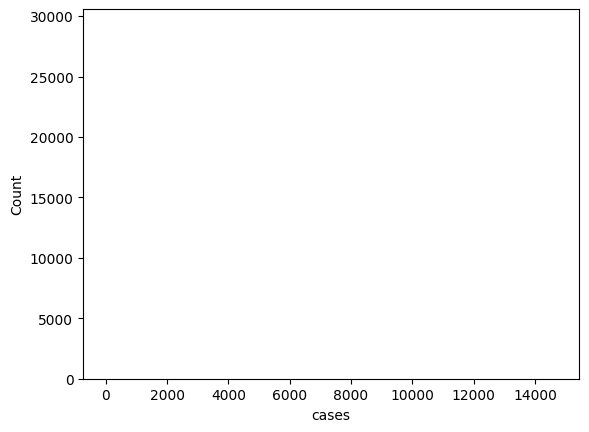

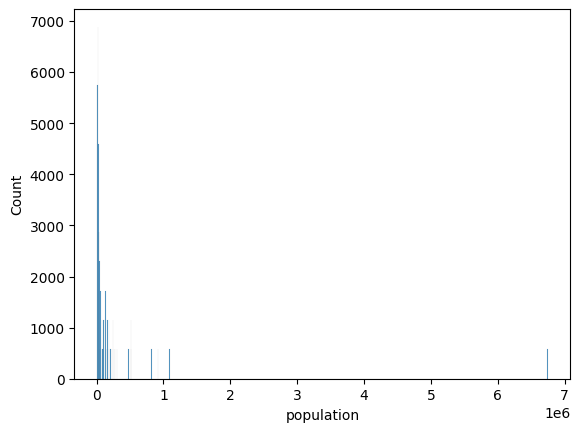

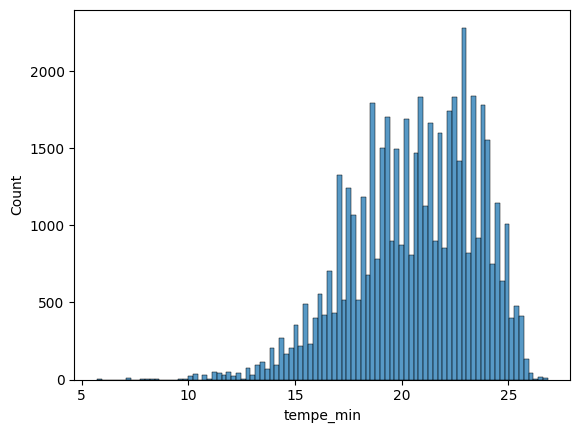

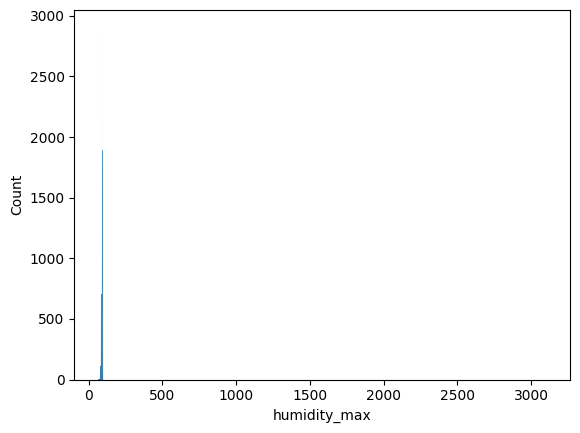

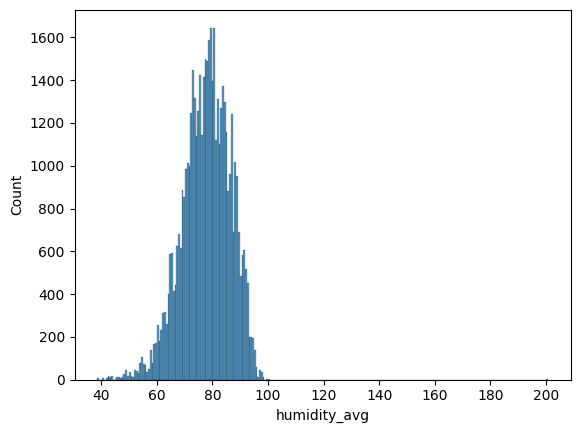

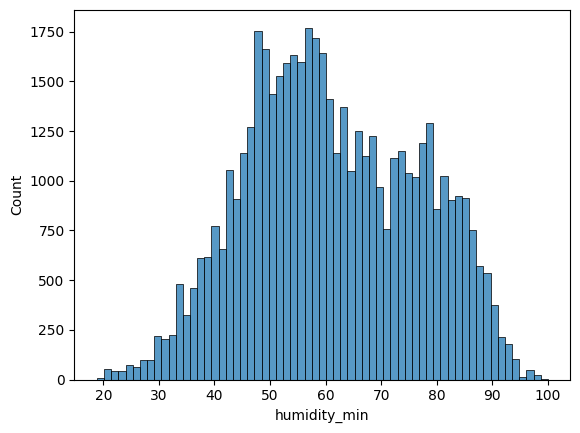

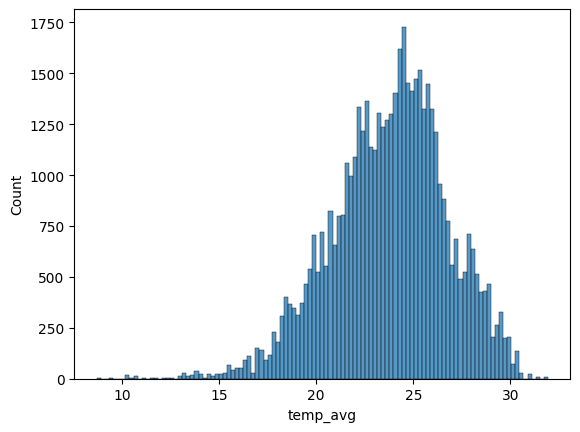

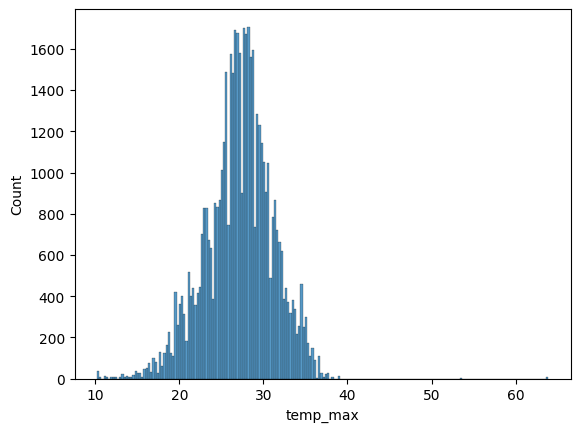

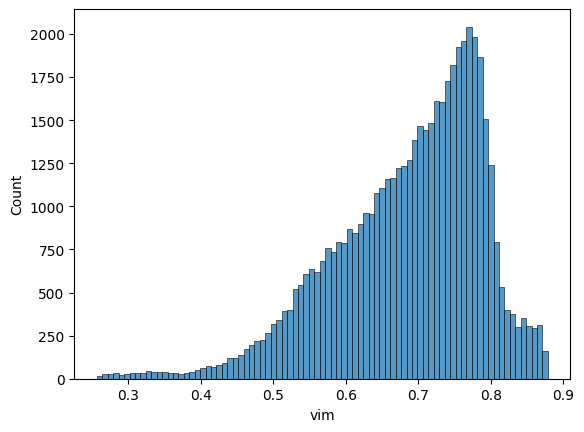

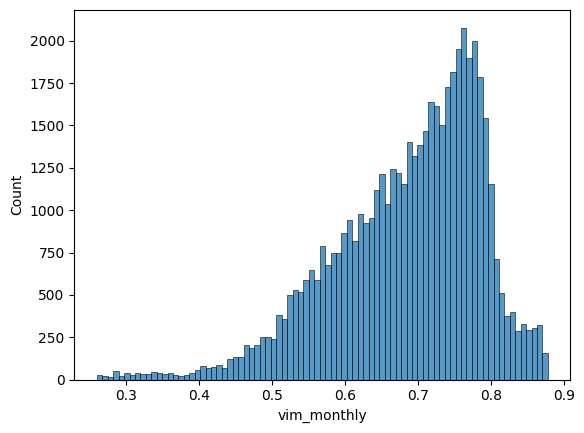

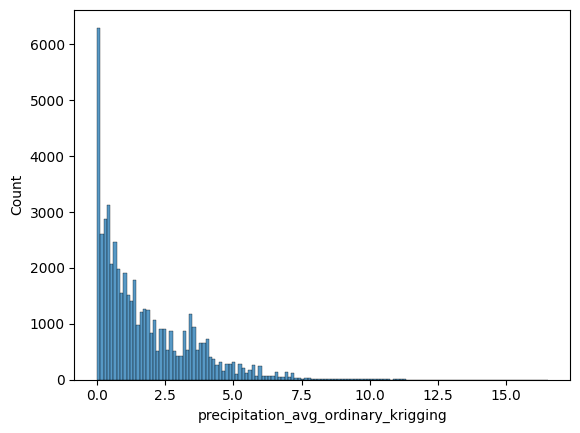

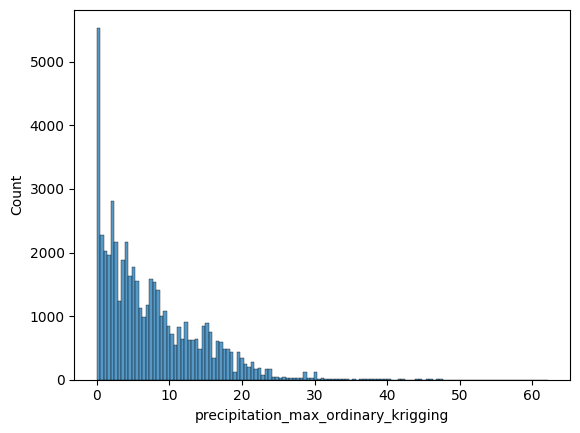

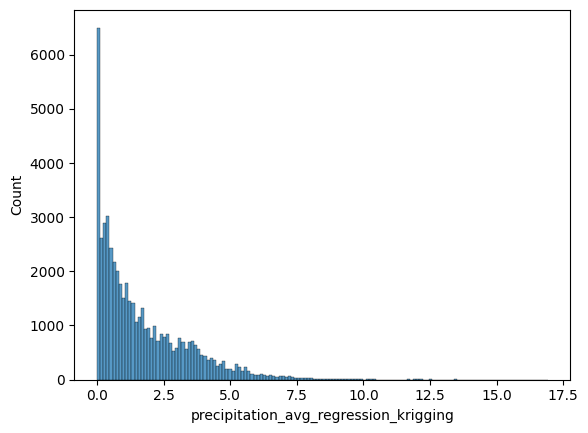

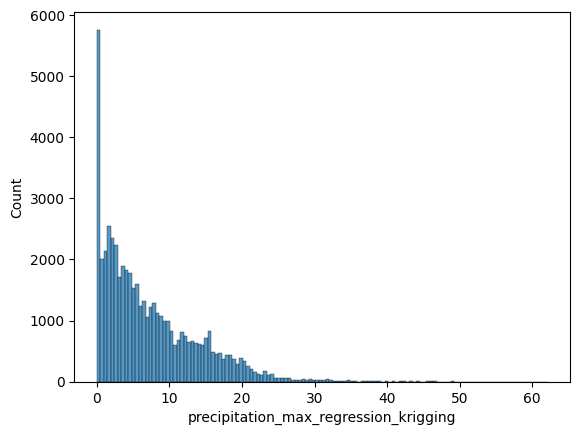

In [54]:
#histogram to understand the distribution
#understand the distribution normalizaton left skewed right skewed
for i in df.select_dtypes(include="number").columns:
    sns.histplot(data=df,x=i)
    plt.show()

What is a Boxplot?

A boxplot is a visual representation of the distribution of a dataset, highlighting:

Median: The line inside the box represents the median of the data.
Interquartile Range (IQR):The box spans from the 25th percentile (Q1) to the 75th percentile (Q3).
IQR = Q3 - Q1.
Whiskers:Extend to the smallest and largest values within 1.5 * IQR from Q1 and Q3, respectively.
Outliers: Data points beyond 1.5 * IQR from Q1 or Q3 are plotted as individual points and are considered potential outliers.

Why Use Boxplots?

Identify Outliers:The individual dots outside the whiskers represent potential outliers.

Understand Distribution:

Skewness in data can be observed:
Whiskers of unequal length indicate skewed data.
Compare Variability:
The size of the box reflects the variability in the data.

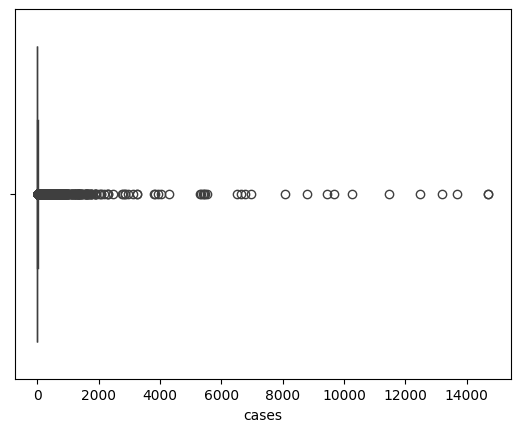

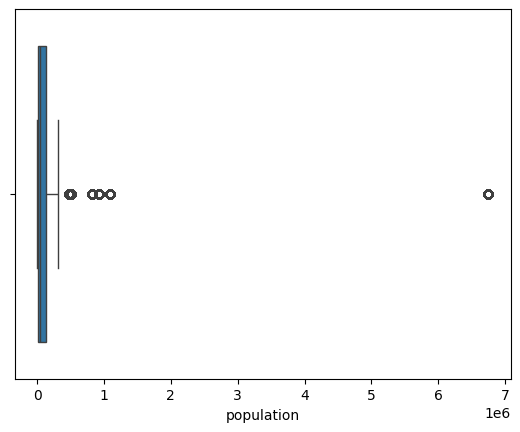

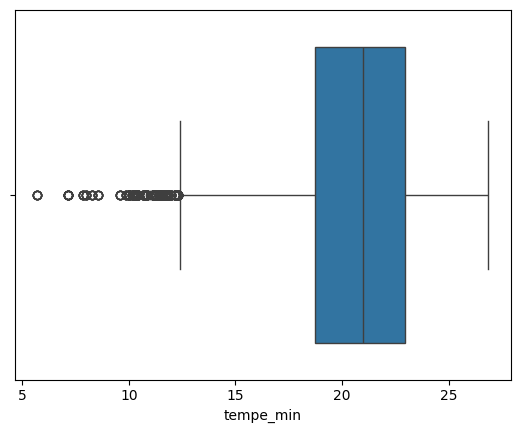

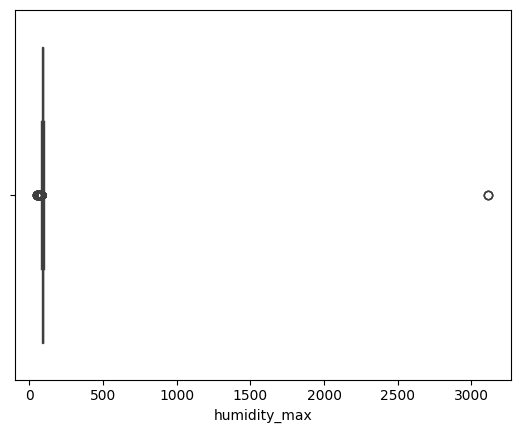

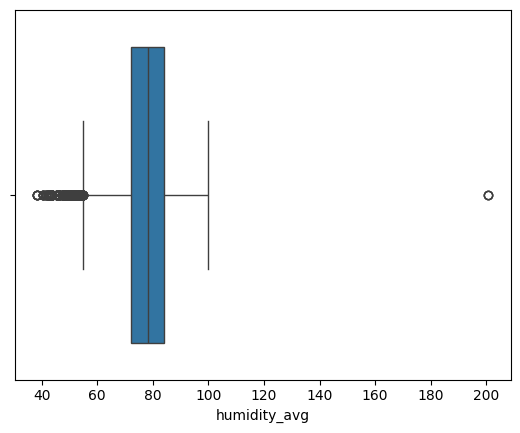

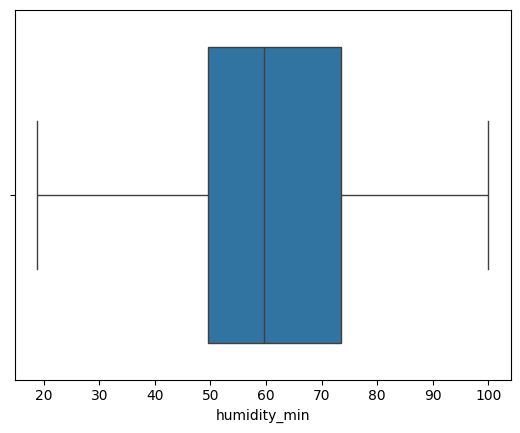

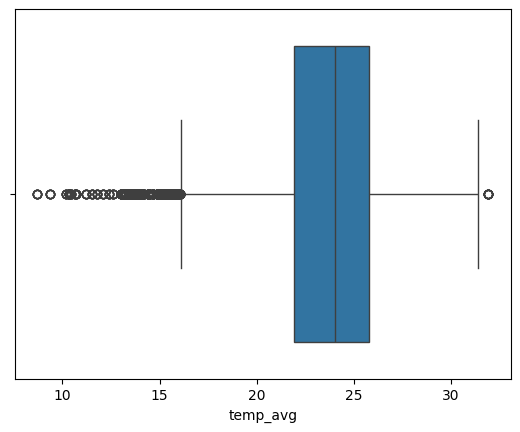

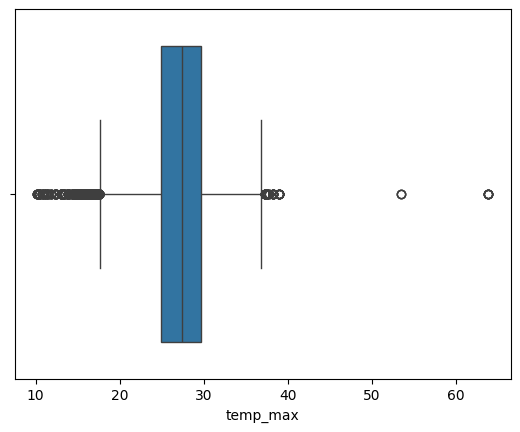

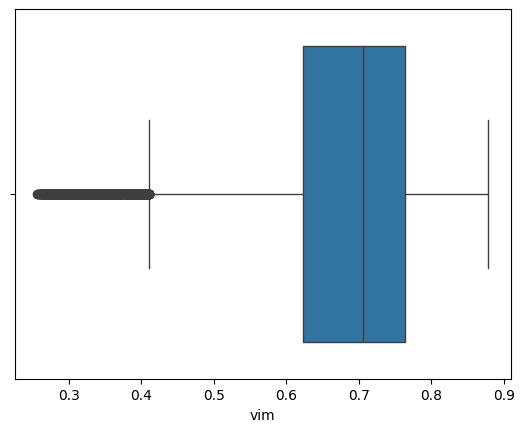

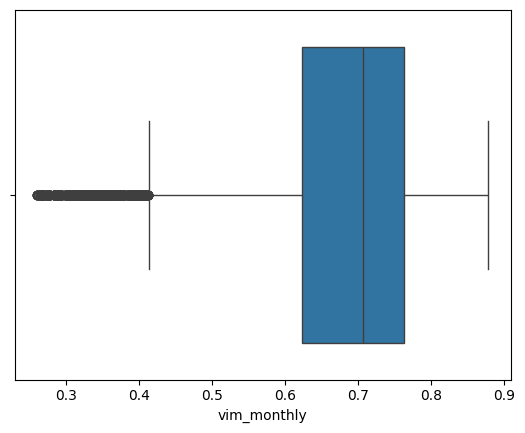

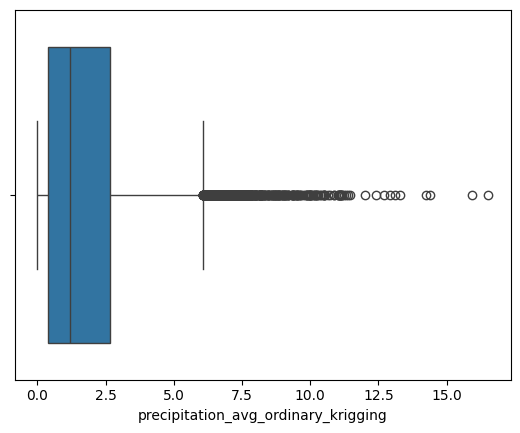

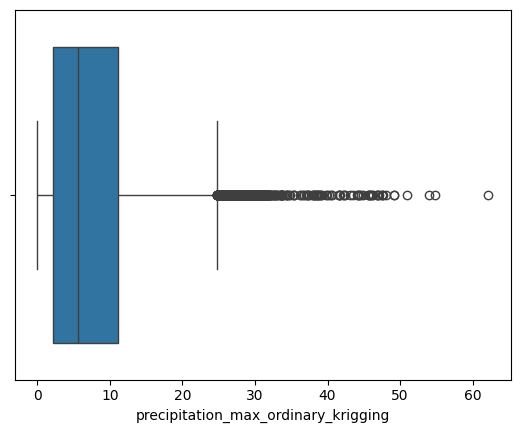

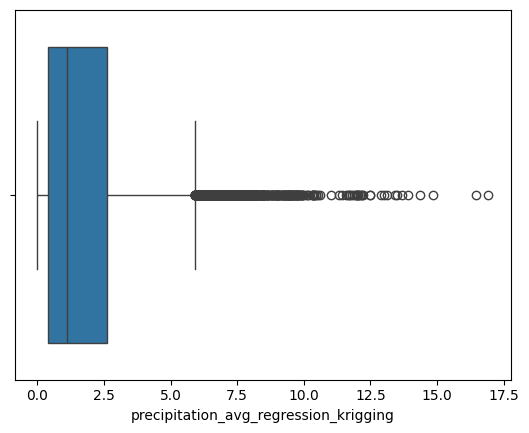

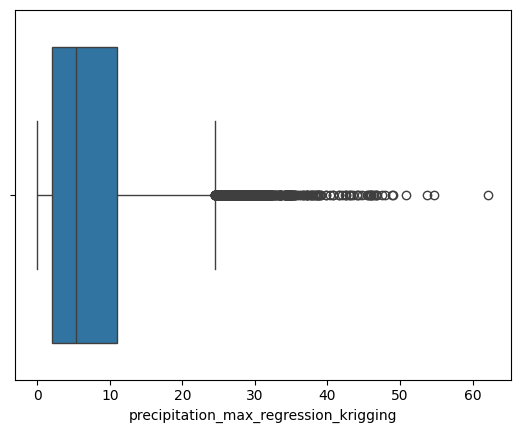

In [55]:
#boxflot to identify outliers
for i in df.select_dtypes(include="number").columns:
    sns.boxplot(data=df,x=i)
    plt.show()


Purpose of Scatter Plots in Data Analysis
Visualize Relationships:

Assess if there is a correlation between a feature and cases.
Positive correlation: As x increases, y increases.
Negative correlation: As x increases, y decreases.
No correlation: No clear trend between x and y.
Detect Patterns and Outliers:

Patterns like linear trends, clusters, or non-linear relationships can be observed.
Outliers appear as points far from the main cluster.
Feature Selection:

In [56]:
#inorder to build the model need to check whether there is a relationship between dependent var and independent var
#scatter plot to understand the relationship , positive negative likewise
df.select_dtypes(include="number").columns

Index(['cases', 'population', 'tempe_min', 'humidity_max', 'humidity_avg',
       'humidity_min', 'temp_avg', 'temp_max', 'vim', 'vim_monthly',
       'precipitation_avg_ordinary_krigging',
       'precipitation_max_ordinary_krigging',
       'precipitation_avg_regression_krigging',
       'precipitation_max_regression_krigging'],
      dtype='object')

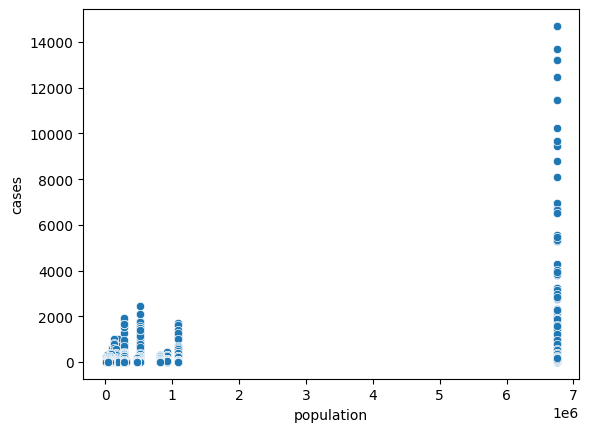

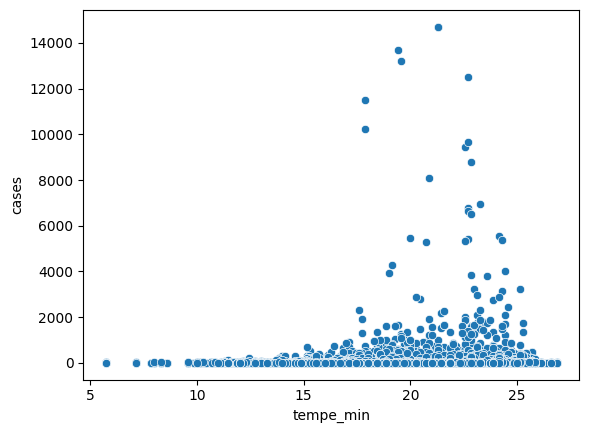

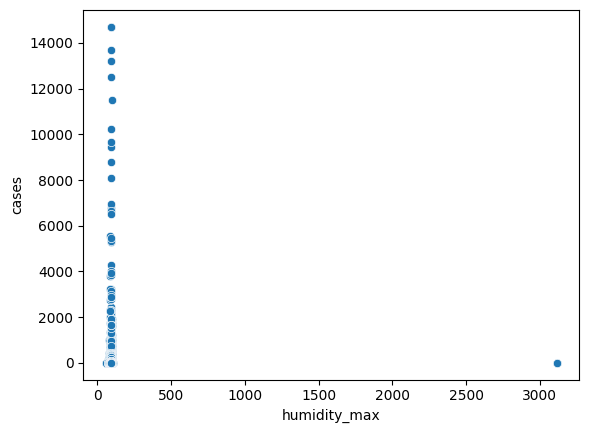

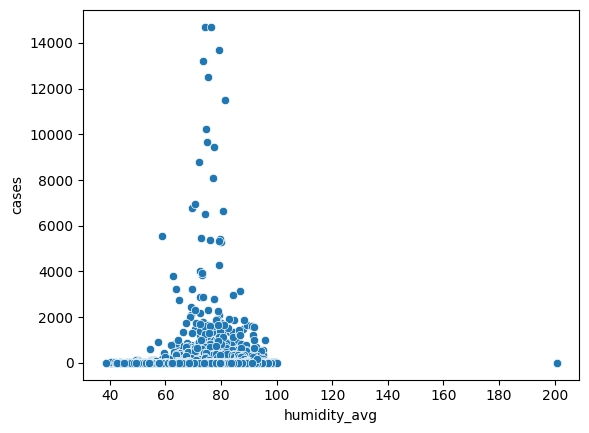

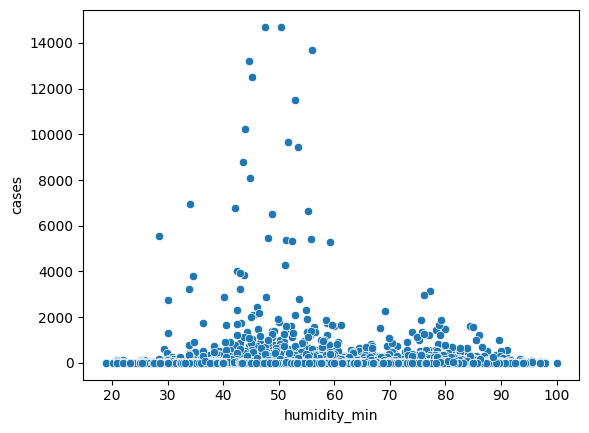

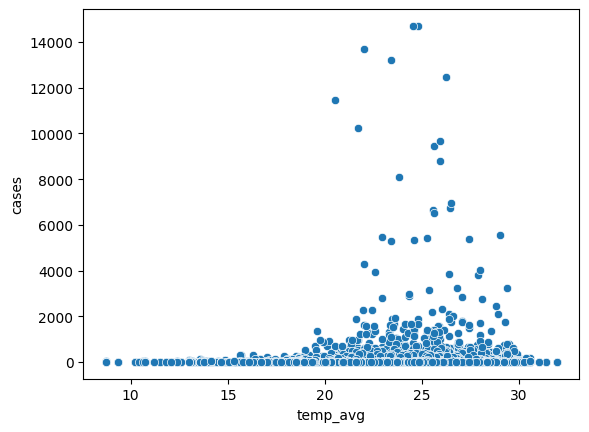

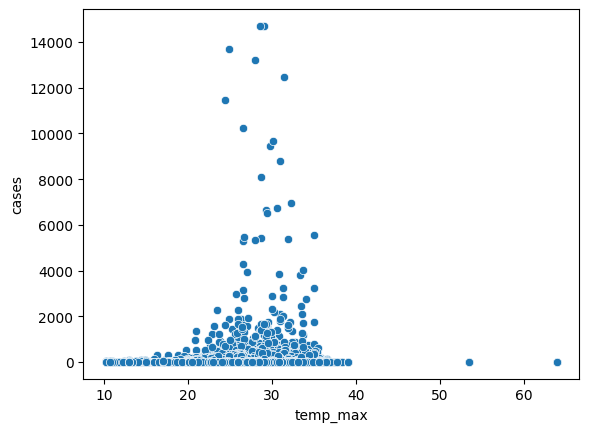

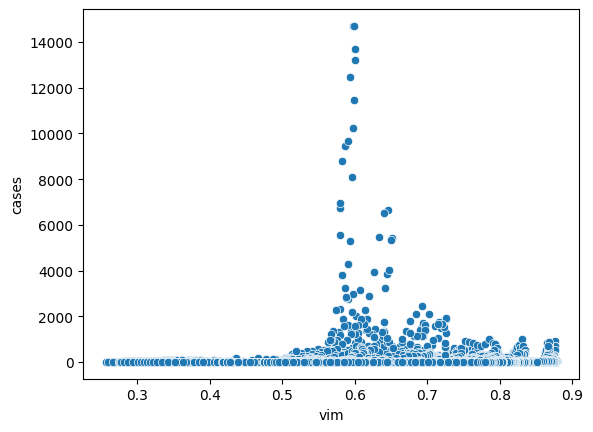

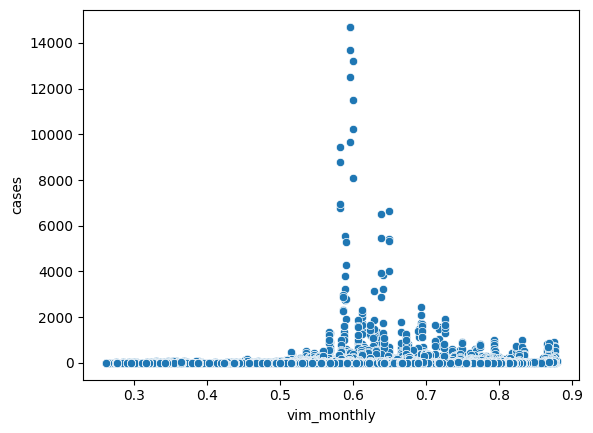

In [57]:
for i in ['population', 'tempe_min', 'humidity_max', 'humidity_avg',
       'humidity_min', 'temp_avg', 'temp_max', 'vim',
       'vim_monthly']:
    sns.scatterplot(data=df,x=i,y='cases')
    plt.show()

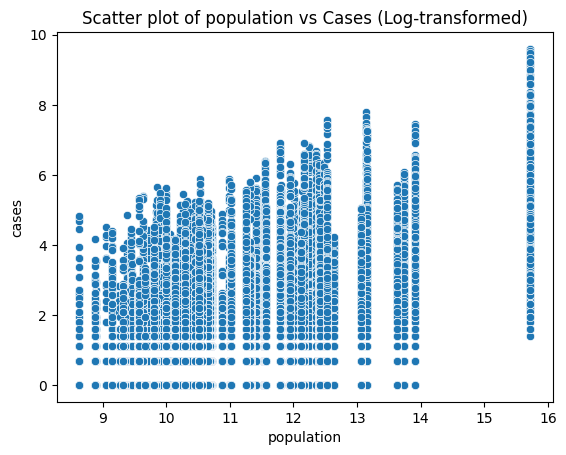

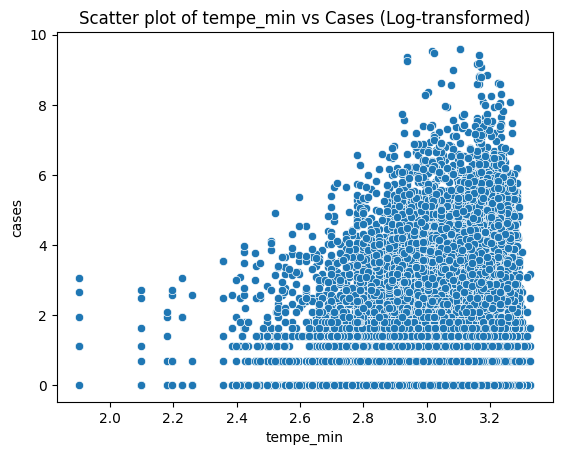

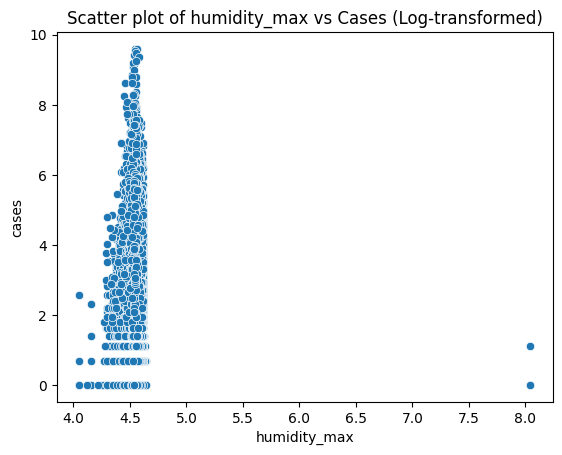

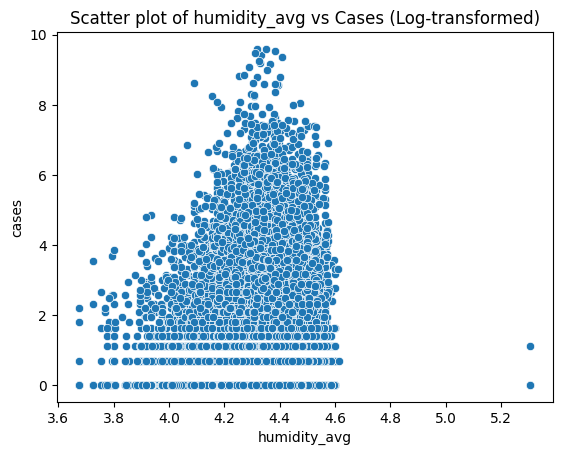

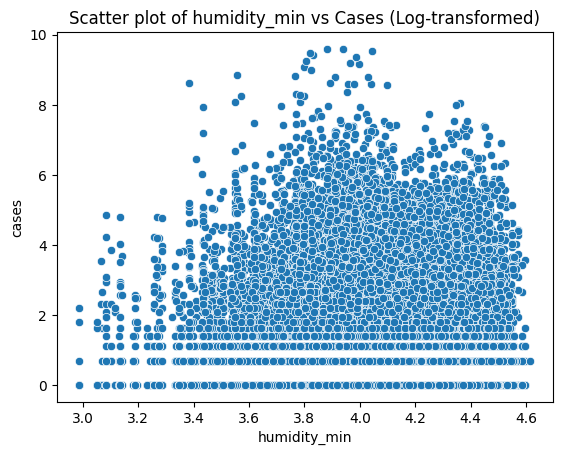

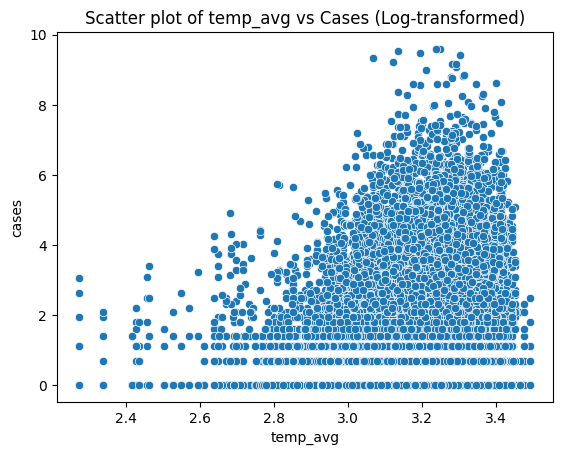

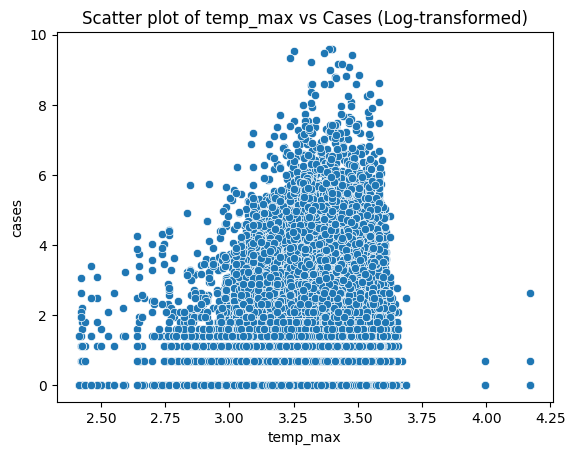

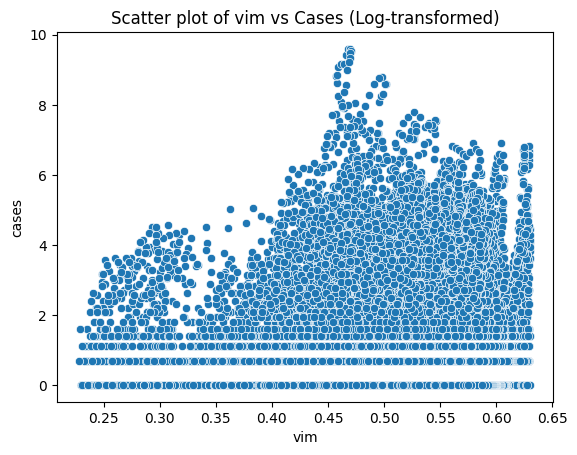

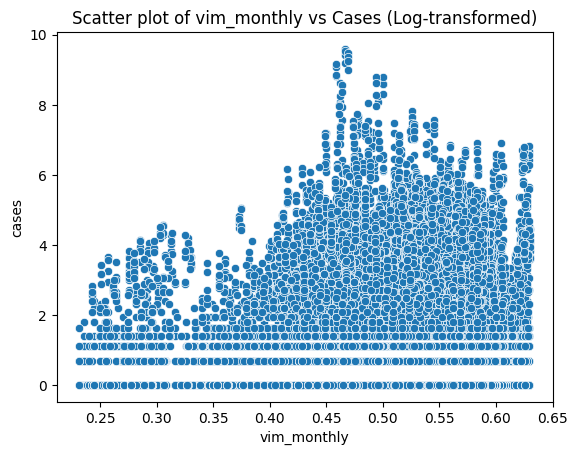

In [58]:
for i in ['population', 'tempe_min', 'humidity_max', 'humidity_avg',
           'humidity_min', 'temp_avg', 'temp_max', 'vim', 'vim_monthly']:
    sns.scatterplot(data=df, x=np.log1p(df[i]), y=np.log1p(df['cases']))  # Using log transformation
    plt.title(f'Scatter plot of {i} vs Cases (Log-transformed)')
    plt.show()


Purpose of Correlation Heatmaps
Understand Relationships:

Correlation values range from -1 to 1:
+1: Perfect positive correlation (both variables increase together).
-1: Perfect negative correlation (one variable decreases as the other increases).
0: No correlation.
Strong correlations (close to ±1) indicate a potential relationship between variables.
Detect Multicollinearity:

Multicollinearity occurs when two or more variables are highly correlated (e.g., correlation > 0.8 or < -0.8).
High multicollinearity can cause instability in regression models and affect feature importance in machine learning.
Feature Selection:

Identify redundant features (those with high correlations with other variables) and consider removing them to simplify your model.
How to Interpret the Heatmap
Diagonal Elements: Always 1, as a variable is perfectly correlated with itself.
Bright Colors: Indicate strong correlations.
Darker Colors: Indicate weaker correlations.
Clusters of High Correlation:
Variables in such clusters may contain redundant information.

<Axes: >

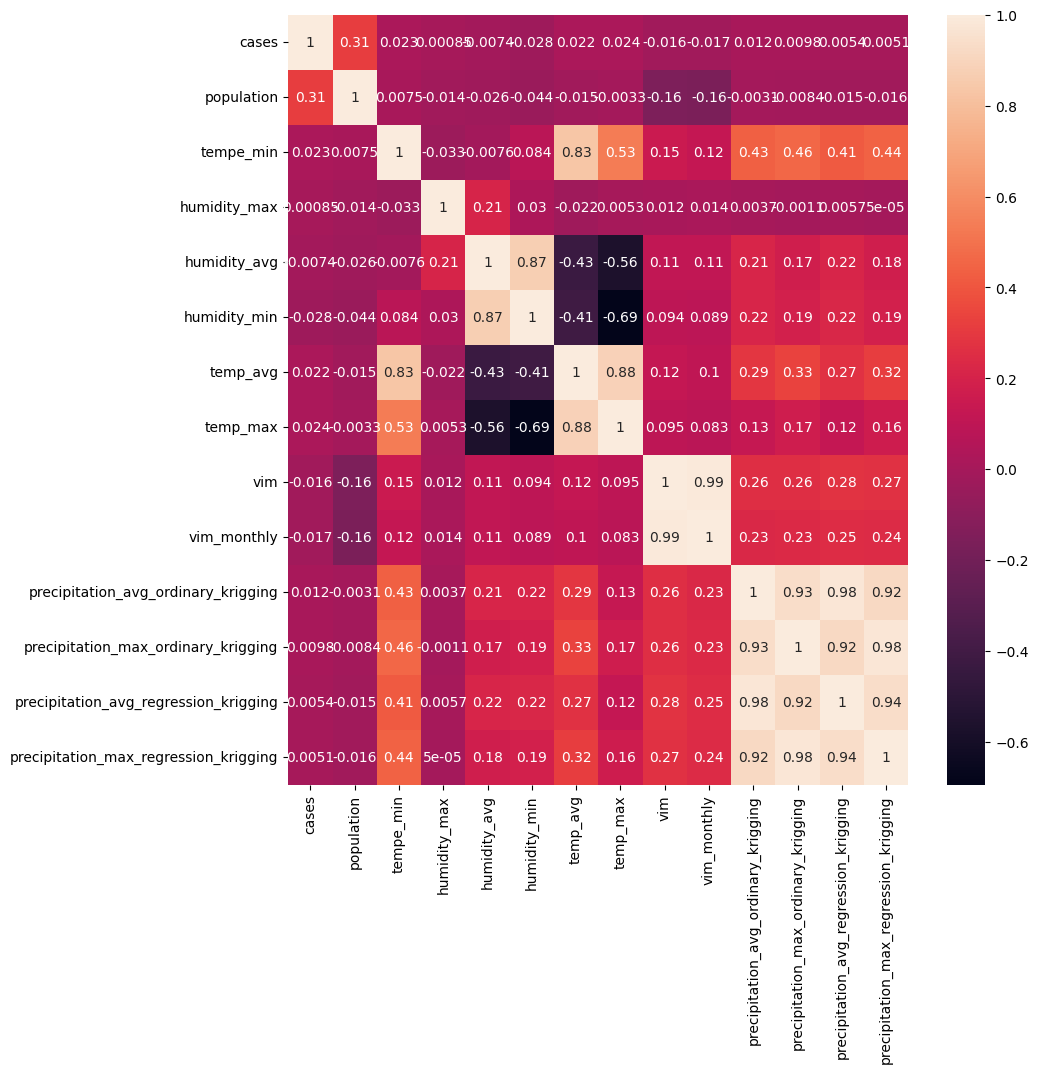

In [59]:
#correlation with heatmap to interpret the relationship and multicolliniarity
s = df.select_dtypes(include="number").corr()
plt.figure(figsize=(10,10))
sns.heatmap(s,annot=True)

Set a Correlation Threshold: Highlight only correlations above a certain threshold to focus on strong relationships:

<Axes: >

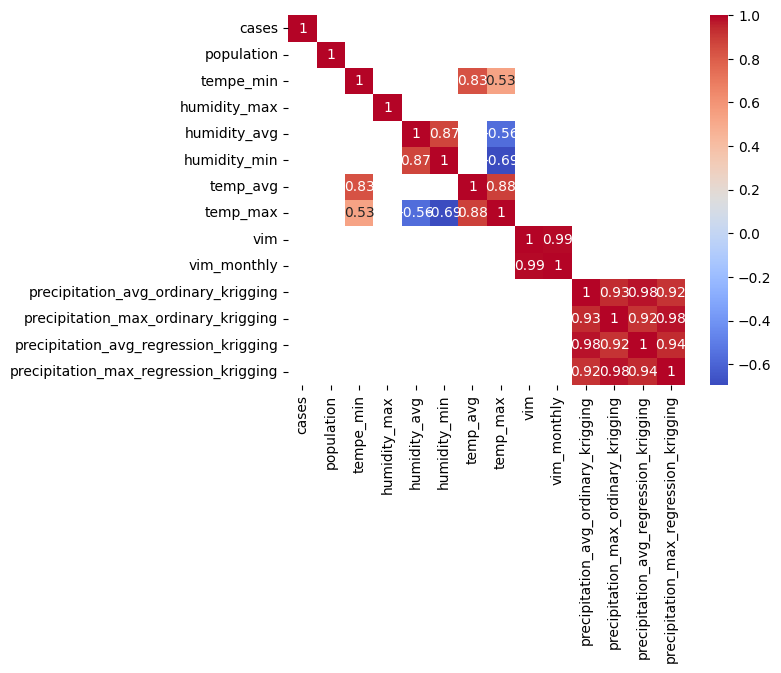

In [60]:
sns.heatmap(s, annot=True, mask=np.abs(s) < 0.5, cmap="coolwarm")


FILLING MISSING VALUES

In [61]:
df.isnull().sum()

date                                        0
week                                        0
cases                                       0
population                                  0
tempe_min                                   0
humidity_max                             1957
humidity_avg                             1957
humidity_min                             1957
temp_avg                                 1957
temp_max                                 1957
city                                        0
geocode                                     0
vim                                         0
vim_monthly                                 0
precipitation_avg_ordinary_krigging         0
precipitation_max_ordinary_krigging         0
precipitation_avg_regression_krigging       0
precipitation_max_regression_krigging       0
dtype: int64

In [62]:
from sklearn.impute import KNNImputer

# Sample grouped KNN Imputation with tracking statistics
def knn_impute_by_group(df, group_col, k=5):
    imputer = KNNImputer(n_neighbors=k)
    imputed_dfs = []  # To store imputed groups
    imputed_stats = []  # To track stats for imputed values
    
    for region, group in df.groupby(group_col):
        # Identify missing values
        group_numeric = group.select_dtypes(include='number')
        missing_mask = group_numeric.isnull()

        # Perform KNN Imputation
        group_imputed = pd.DataFrame(
            imputer.fit_transform(group_numeric),
            columns=group_numeric.columns,
            index=group_numeric.index
        )
        
        # Calculate imputed values only
        imputed_only = group_imputed.where(missing_mask)  # Keeps only imputed values
        mean_imputed = imputed_only.mean(skipna=True)     # Mean of imputed values
        count_imputed = imputed_only.notnull().sum()      # Count of imputed values
        
        # Append stats to a list
        stats = {'region': region, 'mean_imputed': mean_imputed, 'count_imputed': count_imputed}
        imputed_stats.append(stats)
        
        # Update group with imputed values
        group.loc[:, group_numeric.columns] = group_imputed
        imputed_dfs.append(group)
    
    # Combine all groups back together
    imputed_df = pd.concat(imputed_dfs)

    total_imputed = sum(stat['count_imputed'].sum() for stat in imputed_stats)

    
    # Return imputed DataFrame and statistics
    return imputed_df, imputed_stats , total_imputed

# Example usage
df, imputed_stats ,total_imputed= knn_impute_by_group(df, group_col='geocode', k=5)

print(total_imputed)

# Print overall statistics
for stat in imputed_stats:
    print(f"Region: {stat['region']}")
    print("Mean of Imputed Values:")
    print(stat['mean_imputed'])
    print("Count of Imputed Values:")
    print(stat['count_imputed'])
    print("-" * 30)
    


9785
Region: 3300100
Mean of Imputed Values:
cases                                          NaN
population                                     NaN
tempe_min                                      NaN
humidity_max                             89.692519
humidity_avg                             71.681024
humidity_min                             57.692558
temp_avg                                 21.877907
temp_max                                 25.452661
vim                                            NaN
vim_monthly                                    NaN
precipitation_avg_ordinary_krigging            NaN
precipitation_max_ordinary_krigging            NaN
precipitation_avg_regression_krigging          NaN
precipitation_max_regression_krigging          NaN
dtype: float64
Count of Imputed Values:
cases                                     0
population                                0
tempe_min                                 0
humidity_max                             17
humidity_avg             

In [63]:
df.isnull().sum()

date                                     0
week                                     0
cases                                    0
population                               0
tempe_min                                0
humidity_max                             0
humidity_avg                             0
humidity_min                             0
temp_avg                                 0
temp_max                                 0
city                                     0
geocode                                  0
vim                                      0
vim_monthly                              0
precipitation_avg_ordinary_krigging      0
precipitation_max_ordinary_krigging      0
precipitation_avg_regression_krigging    0
precipitation_max_regression_krigging    0
dtype: int64

In [64]:
df = df.drop(columns=['city'])


In [65]:
df.head(70)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,geocode,vim,vim_monthly,precipitation_avg_ordinary_krigging,precipitation_max_ordinary_krigging,precipitation_avg_regression_krigging,precipitation_max_regression_krigging
0,2012-01-01,201201,32,207044.0,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979
1,2012-01-08,201202,40,207044.0,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583
2,2012-01-15,201203,19,207044.0,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368
3,2012-01-22,201204,33,207044.0,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767
4,2012-01-29,201205,36,207044.0,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2013-03-31,201314,612,207044.0,20.285714,97.428571,76.640063,56.000000,24.900870,28.571429,3300100,0.876090,0.875367,2.5207,12.3094,2.6013,12.9567
66,2013-04-07,201315,709,207044.0,20.142857,87.428571,73.522143,58.857143,23.513070,26.571429,3300100,0.875956,0.875800,1.7950,8.0429,1.7166,7.9763
67,2013-04-14,201316,537,207044.0,15.285714,89.714286,68.131868,50.571429,20.725275,24.714286,3300100,0.875715,0.875800,0.8844,4.7219,0.5297,2.4955
68,2013-04-21,201317,286,207044.0,14.000000,93.142857,63.929012,44.428571,20.488535,24.857143,3300100,0.875220,0.875800,0.3933,1.4821,0.3658,1.4329


In [66]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(sparse_output=False), ['geocode'])  # One-hot encode 'geocode'
], remainder='passthrough')  # Keep all other columns as is

transformed_data = ct.fit_transform(df)

# Get feature names
feature_names = ct.get_feature_names_out()

# Clean feature names to remove 'remainder__' prefix
cleaned_feature_names = [name.split('__')[-1] if 'remainder__' in name else name for name in feature_names]

# Convert transformed data back to DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=cleaned_feature_names)

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if col in transformed_df.columns:
        transformed_df[col] = pd.to_numeric(transformed_df[col], errors='coerce')

if 'date' in transformed_df.columns:
    transformed_df['date'] = pd.to_datetime(transformed_df['date'], errors='coerce')

print(transformed_df.dtypes)
df= transformed_df

onehot__geocode_3300100                   object
onehot__geocode_3300159                   object
onehot__geocode_3300209                   object
onehot__geocode_3300225                   object
onehot__geocode_3300233                   object
                                          ...   
vim_monthly                              float64
precipitation_avg_ordinary_krigging      float64
precipitation_max_ordinary_krigging      float64
precipitation_avg_regression_krigging    float64
precipitation_max_regression_krigging    float64
Length: 107, dtype: object


In [67]:
df.head(10)

,onehot__geocode_3300100,onehot__geocode_3300159,onehot__geocode_3300209,onehot__geocode_3300225,onehot__geocode_3300233,onehot__geocode_3300258,onehot__geocode_3300308,onehot__geocode_3300407,onehot__geocode_3300456,onehot__geocode_3300506,...,humidity_avg,humidity_min,temp_avg,temp_max,vim,vim_monthly,precipitation_avg_ordinary_krigging,precipitation_max_ordinary_krigging,precipitation_avg_regression_krigging,precipitation_max_regression_krigging
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.514486,35.000000,25.048951,29.571429,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.357393,47.428571,23.737513,26.571429,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65.236264,45.571429,24.413187,28.714286,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.362637,43.428571,24.879121,28.857143,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.885924,33.142857,25.989992,30.428571,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,43.494048,22.142857,28.614927,33.571429,0.857159,0.858000,3.8170,25.9830,3.8228,26.0478
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.778911,40.571429,25.791314,29.571429,0.858241,0.858000,4.0861,29.4086,4.0920,29.0110
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.458425,34.428571,27.253296,31.285714,0.859142,0.858000,0.5962,4.0133,0.4783,3.2643
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,43.760989,21.285714,28.902930,34.000000,0.860082,0.858000,0.8143,3.8456,0.8171,3.8703
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.333639,28.428571,26.467491,30.857143,0.860933,0.861567,1.1867,5.3867,0.6647,3.8741


In [68]:
df.shape

(52234, 107)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52234 entries, 0 to 52233
Columns: 107 entries, onehot__geocode_3300100 to precipitation_max_regression_krigging
dtypes: datetime64[ns](1), float64(13), int64(1), object(92)
memory usage: 42.6+ MB


ADDING CYCLIC FEATURE TO THE DATE

date_ordinal:  Represents the date as a continuous number of days since a fixed point (e.g., 1st January 0001).
week_sin and week_cos:Encodes the cyclic nature of weeks, ensuring that weeks like 52 and 1 are close in representation.

When training the models

Use a combination of columns based on the model type:

Tree-based models (e.g., CatBoost, Decision Trees):

Use date_ordinal, year, month (as raw numbers, no need for sine/cosine).

SVR/RBF:

Use week_sin, week_cos, month_sin, month_cos, normalized date_ordinal, and normalized year.

LSTM:
Include all temporal features, as LSTM can model both linear and cyclic trends.

In [70]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')

In [71]:
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)


In [72]:
df.head(40)


,onehot__geocode_3300100,onehot__geocode_3300159,onehot__geocode_3300209,onehot__geocode_3300225,onehot__geocode_3300233,onehot__geocode_3300258,onehot__geocode_3300308,onehot__geocode_3300407,onehot__geocode_3300456,onehot__geocode_3300506,...,precipitation_max_ordinary_krigging,precipitation_avg_regression_krigging,precipitation_max_regression_krigging,date_ordinal,year,month,month_sin,month_cos,week_sin,week_cos
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.3375,5.2038,18.7979,734503,2012,1,5.000000e-01,8.660254e-01,1.000000e+00,7.185429e-13
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.5375,3.9114,16.8583,734510,2012,1,5.000000e-01,8.660254e-01,9.927089e-01,-1.205367e-01
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0500,1.7556,3.1368,734517,2012,1,5.000000e-01,8.660254e-01,9.709418e-01,-2.393157e-01
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.7059,1.4138,5.2767,734524,2012,1,5.000000e-01,8.660254e-01,9.350162e-01,-3.546049e-01
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.3826,2.0057,7.8749,734531,2012,1,5.000000e-01,8.660254e-01,8.854560e-01,-4.647232e-01
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.9830,3.8228,26.0478,734538,2012,2,8.660254e-01,5.000000e-01,8.229839e-01,-5.680647e-01
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.4086,4.0920,29.0110,734545,2012,2,8.660254e-01,5.000000e-01,7.485107e-01,-6.631227e-01
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0133,0.4783,3.2643,734552,2012,2,8.660254e-01,5.000000e-01,6.631227e-01,-7.485107e-01
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.8456,0.8171,3.8703,734559,2012,2,8.660254e-01,5.000000e-01,5.680647e-01,-8.229839e-01
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.3867,0.6647,3.8741,734566,2012,3,1.000000e+00,6.123234e-17,4.647232e-01,-8.854560e-01


In [73]:
print(df.dtypes)


new_columns = ['date_ordinal', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'year', 'month','week']
print("\nData types of newly added columns:")
print(df[new_columns].dtypes)


onehot__geocode_3300100     object
onehot__geocode_3300159     object
onehot__geocode_3300209     object
onehot__geocode_3300225     object
onehot__geocode_3300233     object
                            ...   
month                        int32
month_sin                  float64
month_cos                  float64
week_sin                   float64
week_cos                   float64
Length: 114, dtype: object

Data types of newly added columns:
date_ordinal      int64
week_sin        float64
week_cos        float64
month_sin       float64
month_cos       float64
year              int32
month             int32
week              int64
dtype: object




FEATURE SCALING
min-MAX is choosen because it's sensitive to the outliers

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52234 entries, 0 to 52233
Columns: 114 entries, onehot__geocode_3300100 to week_cos
dtypes: datetime64[ns](1), float64(17), int32(2), int64(3), object(91)
memory usage: 45.0+ MB


In [75]:
from sklearn.preprocessing import MinMaxScaler

# Specify the columns to exclude from scaling
#cases waw removed from scaling - some model need to scale that as well
#date_ordinal,year,month also need to scale according to the model
new_columns = ['date_ordinal', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'year', 'month', 'week','cases']

# Select numeric columns excluding the ones in `new_columns`
numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in new_columns]


scaler = MinMaxScaler()


df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.head(10)



,onehot__geocode_3300100,onehot__geocode_3300159,onehot__geocode_3300209,onehot__geocode_3300225,onehot__geocode_3300233,onehot__geocode_3300258,onehot__geocode_3300308,onehot__geocode_3300407,onehot__geocode_3300456,onehot__geocode_3300506,...,precipitation_max_ordinary_krigging,precipitation_avg_regression_krigging,precipitation_max_regression_krigging,date_ordinal,year,month,month_sin,month_cos,week_sin,week_cos
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.294963,0.307459,0.302329,734503,2012,1,0.500000,8.660254e-01,1.000000,7.185429e-13
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.266010,0.231099,0.271134,734510,2012,1,0.500000,8.660254e-01,0.992709,-1.205367e-01
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.081230,0.103727,0.050450,734517,2012,1,0.500000,8.660254e-01,0.970942,-2.393157e-01
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.091781,0.083532,0.084866,734524,2012,1,0.500000,8.660254e-01,0.935016,-3.546049e-01
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.150921,0.118504,0.126653,734531,2012,1,0.500000,8.660254e-01,0.885456,-4.647232e-01
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.417943,0.225864,0.418930,734538,2012,2,0.866025,5.000000e-01,0.822984,-5.680647e-01
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.473044,0.241770,0.466587,734545,2012,2,0.866025,5.000000e-01,0.748511,-6.631227e-01
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.064555,0.028260,0.052500,734552,2012,2,0.866025,5.000000e-01,0.663123,-7.485107e-01
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061857,0.048277,0.062246,734559,2012,2,0.866025,5.000000e-01,0.568065,-8.229839e-01
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.086646,0.039273,0.062308,734566,2012,3,1.000000,6.123234e-17,0.464723,-8.854560e-01


here we have week column in numeric form
also week in cosine,sine form

date is removing since ordinal date represent the date.

In [76]:
numeric_cols = df.select_dtypes(include=['float64']).columns
print("Numeric Columns:", numeric_cols)


Numeric Columns: Index(['population', 'tempe_min', 'humidity_max', 'humidity_avg',
       'humidity_min', 'temp_avg', 'temp_max', 'vim', 'vim_monthly',
       'precipitation_avg_ordinary_krigging',
       'precipitation_max_ordinary_krigging',
       'precipitation_avg_regression_krigging',
       'precipitation_max_regression_krigging', 'month_sin', 'month_cos',
       'week_sin', 'week_cos'],
      dtype='object')


In [77]:
df.shape

(52234, 114)

In [78]:
df.isnull().sum()

onehot__geocode_3300100    0
onehot__geocode_3300159    0
onehot__geocode_3300209    0
onehot__geocode_3300225    0
onehot__geocode_3300233    0
                          ..
month                      0
month_sin                  0
month_cos                  0
week_sin                   0
week_cos                   0
Length: 114, dtype: int64

In [79]:
df.to_csv('final_dataset.csv', index=False)


SPLITTING

In [80]:

train_df = df[df['date'].dt.year <= 2020]
test_df = df[df['date'].dt.year >= 2021]

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

X_train = train_df.drop(columns=['cases'])
y_train = train_df[['cases']]

X_test = test_df.drop(columns=['cases'])
y_test = train_df[['cases']]



Training set shape: (42770, 114)
Test set shape: (9464, 114)


In [81]:
X_train.head(50)

,onehot__geocode_3300100,onehot__geocode_3300159,onehot__geocode_3300209,onehot__geocode_3300225,onehot__geocode_3300233,onehot__geocode_3300258,onehot__geocode_3300308,onehot__geocode_3300407,onehot__geocode_3300456,onehot__geocode_3300506,...,precipitation_max_ordinary_krigging,precipitation_avg_regression_krigging,precipitation_max_regression_krigging,date_ordinal,year,month,month_sin,month_cos,week_sin,week_cos
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.294963,0.307459,0.302329,734503,2012,1,5.000000e-01,8.660254e-01,1.000000e+00,7.185429e-13
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.266010,0.231099,0.271134,734510,2012,1,5.000000e-01,8.660254e-01,9.927089e-01,-1.205367e-01
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.081230,0.103727,0.050450,734517,2012,1,5.000000e-01,8.660254e-01,9.709418e-01,-2.393157e-01
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.091781,0.083532,0.084866,734524,2012,1,5.000000e-01,8.660254e-01,9.350162e-01,-3.546049e-01
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.150921,0.118504,0.126653,734531,2012,1,5.000000e-01,8.660254e-01,8.854560e-01,-4.647232e-01
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.417943,0.225864,0.418930,734538,2012,2,8.660254e-01,5.000000e-01,8.229839e-01,-5.680647e-01
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.473044,0.241770,0.466587,734545,2012,2,8.660254e-01,5.000000e-01,7.485107e-01,-6.631227e-01
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.064555,0.028260,0.052500,734552,2012,2,8.660254e-01,5.000000e-01,6.631227e-01,-7.485107e-01
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061857,0.048277,0.062246,734559,2012,2,8.660254e-01,5.000000e-01,5.680647e-01,-8.229839e-01
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.086646,0.039273,0.062308,734566,2012,3,1.000000e+00,6.123234e-17,4.647232e-01,-8.854560e-01
